# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
print ((open('Data_Dictionary.md').read()))
#np.set_printoptions(threshold=sys.maxsize)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:

# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("azdias")
print(np.shape(azdias))
print(azdias.head())

azdias
(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1 

In [5]:
print("feat_info")
print(np.shape(feat_info))
print(feat_info)

feat_info
(85, 4)
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric              

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum()


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [7]:
for index, value in enumerate(azdias.iteritems()):
    #print(index, value)
    column = value[0]
    missing = feat_info['missing_or_unknown'][index].replace('[','').replace(']','').split(',')
    #print(missing)
    if missing != ['']:
        temp = []
        for m in missing:
            if (m == 'X' or m == 'XX'):
                temp.append(m)
            else:
                temp.append(int(m))
        azdias[column] = azdias[column].replace(temp,np.nan)
                

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

print(azdias.isnull().sum().to_string())

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [9]:
# Investigate patterns in the amount of missing data in each column.

print((azdias.isnull().sum()*100/(azdias.isnull().sum()+azdias.notnull().sum())).to_string())

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias=azdias.drop(["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"], axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

The main aim here is to ensure that we have all the relevant data to help with the cluster analysis. The data seems to be taken from according to features because a couple of features contain the same amount of miising data.

I decided to drop "TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH" because they have highest amounts of missing data, i.e. 99.757636 %, 76.955435 %, 65.596749 %, 53.468668 %, 44.020282 % respectively.





#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?
row_missing = azdias.isnull().sum(axis=1)
print(row_missing.value_counts().sort_index())

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64


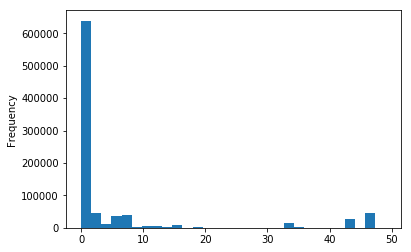

In [12]:
row_missing.plot(kind='hist', bins = 30);

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_1 = azdias[azdias.index.isin(row_missing[row_missing <= 9].index)]
azdias_2 = azdias[azdias.index.isin(row_missing[row_missing > 9].index)]
print(len(azdias_1.index))
print(len(azdias_2.index))
print(len(azdias.index),len(azdias_1.index)+len(azdias_2.index))

774743
116478
891221 891221


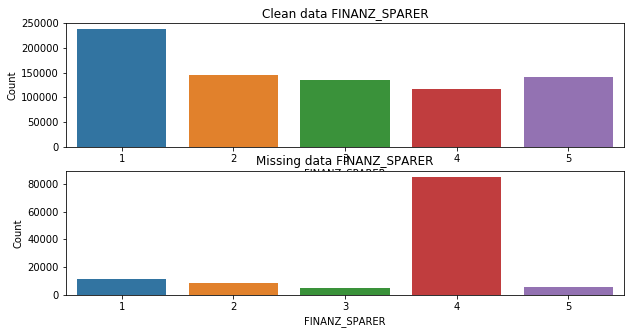

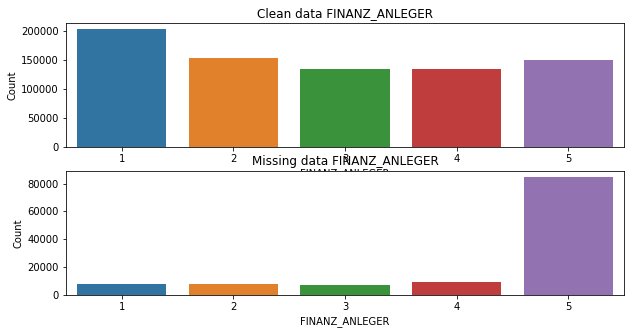

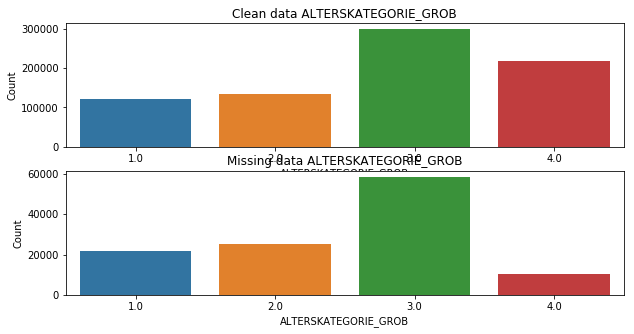

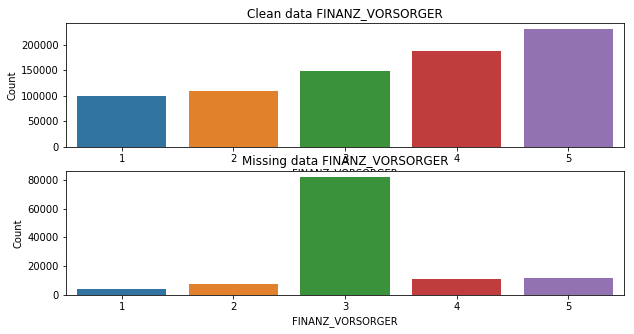

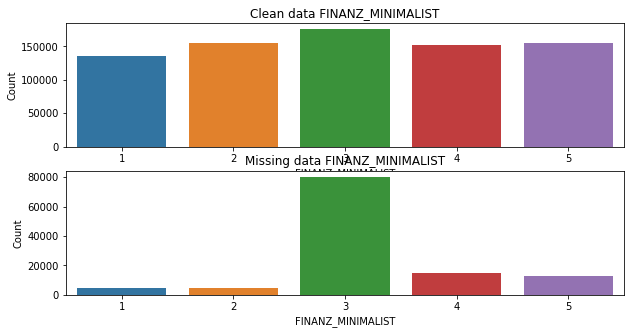

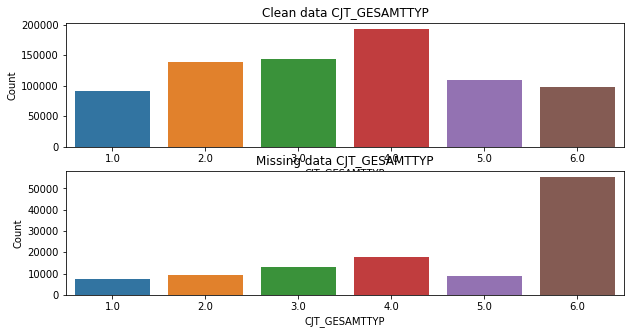

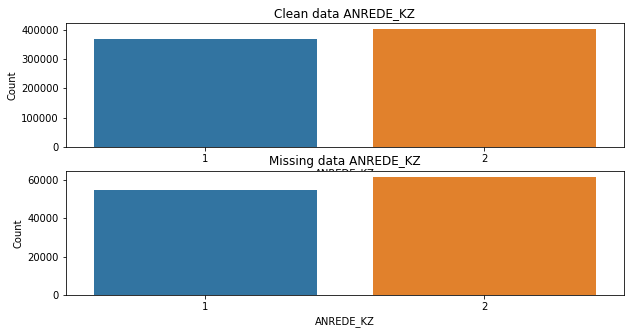

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def draw_plot(column_name):
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(211)
    sns.countplot(azdias_1[column_name])
    plt.title('Clean data %s' %(column_name))
    plt.ylabel('Count')

    plt.subplot(212)
    sns.countplot(azdias_2[column_name])
    plt.title('Missing data %s' %(column_name))
    plt.ylabel('Count')


    
columns = {"ALTERSKATEGORIE_GROB", "ANREDE_KZ", "CJT_GESAMTTYP", "FINANZ_MINIMALIST", "FINANZ_SPARER", "FINANZ_VORSORGER", "FINANZ_ANLEGER"}

for col in columns:
    draw_plot (col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We have to keep the highest level of relevant data to create accurate clusters.  623209 out of 891221 rows are completed which approximates to 70%. I decide to delete all the rows containing more than 9 missing data. This way, we keep 87% of the data but we'll have to impute 148k values later.



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [15]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
display(feat_info[feat_info['type']=='ordinal'])
display(feat_info[feat_info['type']=='categorical'])
display(feat_info[feat_info['type']=='numeric'])
display(feat_info[feat_info['type']=='mixed'])
display(feat_info[feat_info['type']=='interval'])

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
14,HEALTH_TYP,person,ordinal,"[-1,0]"
23,RETOURTYP_BK_S,person,ordinal,[0]
24,SEMIO_SOZ,person,ordinal,"[-1,9]"


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


,attribute,information_level,type,missing_or_unknown
11,GEBURTSJAHR,person,numeric,[0]
44,ANZ_PERSONEN,household,numeric,[]
45,ANZ_TITEL,household,numeric,[]
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]
51,ANZ_HH_TITEL,building,numeric,[]
54,MIN_GEBAEUDEJAHR,building,numeric,[0]
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[]


,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


,attribute,information_level,type,missing_or_unknown
43,ALTER_HH,household,interval,[0]


In [17]:
# Re-encode categorical variable(s) to be kept in the analysis.
#"TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH" dropped columns
feat_info = feat_info[(feat_info.attribute != "TITEL_KZ") & (feat_info.attribute != "AGER_TYP") & (feat_info.attribute != "KK_KUNDENTYP") & (feat_info.attribute != "KBA05_BAUMAX") & (feat_info.attribute != "GEBURTSJAHR") & (feat_info.attribute != "ALTER_HH") ]
categorical = azdias_2[feat_info[feat_info['type'] == 'categorical']['attribute']]
display(categorical.head())



,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1,2.0,4,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
11,1,6.0,4,5.0,0,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
14,1,6.0,4,5.0,0,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
17,1,6.0,4,5.0,0,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
20,2,4.0,3,11.0,1,1.0,1.0,10.0,5.0,1.0,1.0,0.0,1.0,3,3.0,W,4,4C


In [18]:
for col in categorical:
    if (categorical[col].nunique()==2):
        print (col, "has values", categorical[col].unique())

ANREDE_KZ has values [1 2]
GREEN_AVANTGARDE has values [0 1]
SOHO_KZ has values [ nan   0.   1.]
VERS_TYP has values [ nan   1.   2.]
OST_WEST_KZ has values [nan 'W' 'O']


In [19]:
azdias_2['OST_WEST_KZ'] = azdias_2['OST_WEST_KZ'].map({'O': 0, 'W': 1})
azdias_2['OST_WEST_KZ']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0         NaN
11        NaN
14        NaN
17        NaN
20        1.0
24        NaN
26        1.0
30        NaN
35        NaN
46        NaN
48        NaN
53        NaN
54        NaN
61        NaN
62        NaN
69        NaN
75        NaN
76        NaN
81        NaN
83        NaN
90        NaN
97        NaN
99        NaN
103       NaN
106       NaN
108       NaN
109       NaN
112       NaN
133       NaN
137       NaN
         ... 
891049    NaN
891055    NaN
891061    NaN
891062    1.0
891063    NaN
891064    NaN
891069    1.0
891072    NaN
891074    NaN
891092    NaN
891095    NaN
891100    NaN
891117    1.0
891119    1.0
891120    1.0
891130    NaN
891137    NaN
891140    NaN
891154    1.0
891159    NaN
891164    NaN
891169    1.0
891170    1.0
891171    NaN
891172    1.0
891173    1.0
891175    NaN
891185    NaN
891187    NaN
891203    1.0
Name: OST_WEST_KZ, Length: 116478, dtype: float64

In [20]:
for col in categorical:
    if (categorical[col].nunique()>2):
        print (col, "has values", categorical[col].unique())

CJT_GESAMTTYP has values [  2.   6.   4.   3.   5.   1.  nan]
FINANZTYP has values [4 3 1 6 2 5]
GFK_URLAUBERTYP has values [ 10.   5.  11.   2.   7.   1.   9.   8.  12.  nan   4.   6.   3.]
LP_FAMILIE_FEIN has values [  2.  nan   1.  10.   3.   5.   9.   7.  11.   8.   6.   4.]
LP_FAMILIE_GROB has values [  2.  nan   1.   5.   3.   4.]
LP_STATUS_FEIN has values [  1.   5.  10.   8.   4.   9.   2.   6.  nan   3.   7.]
LP_STATUS_GROB has values [  1.   2.   5.   4.   3.  nan]
NATIONALITAET_KZ has values [ nan   1.   3.   2.]
SHOPPER_TYP has values [ nan   1.   3.   2.   0.]
ZABEOTYP has values [3 1 4 2 5 6]
GEBAEUDETYP has values [ nan   3.   1.   8.   2.   6.   4.]
CAMEO_DEUG_2015 has values [nan '4' '6' '5' '3' '2' '7' '9' '8' '1']
CAMEO_DEU_2015 has values [nan '4C' '6B' '5D' '3C' '2B' '2A' '3A' '3B' '2D' '7B' '5B' '4E' '4A' '2C'
 '9A' '8B' '7C' '5A' '8D' '1D' '9C' '6A' '1B' '7E' '1C' '6C' '3D' '8A' '7A'
 '5C' '9B' '7D' '4B' '6D' '1E' '9E' '1A' '6E' '8C' '9D' '5F' '4D' '5E' '6F']


In [21]:
azdias_2 = azdias_2.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB','GEBAEUDETYP','CAMEO_DEU_2015'],axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

We'll first classify the categorical variables as binary or multi-valued. There are 5 binary variables and 13 multi-valued variables. We'll one hot encode the multi-valued attributes. "CJT_GESAMTTYP", "FINANZTYP", "NATIONALITAET_KZ", "SHOPPER_TYP","ZABEOTYP" are person-level features. "LP_FAMILIE_FEIN","LP_FAMILIE_GROB","LP_STATUS_FEIN", and "LP_STATUS_GROB" are the fein/grob features and it was decided to drop grob features. "CAMEO_DEUG_2015", and "CAMEO_DEU_2015" are related to lifestyle topology. It was decided to drop CAMEO_DEU_2015 in order to keep a lower level detail from CAMEO_DEUG_2015 feature. GEBAEUDETYP is related to ANZ_HAUSHALTE_AKTIV so it was decided to drop this feature. GFK_URLAUBERTYP is to be kept as it is a peron-level feature.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_2['PRAEGENDE_JUGENDJAHRE'].unique()

array([ nan,  11.,   8.,  14.,  15.,  10.,   3.,   1.,   5.,   4.,   7.,
         9.,   2.,  12.,   6.,  13.])

In [23]:
mainstream = []

for x in azdias_2['PRAEGENDE_JUGENDJAHRE']:
    if x in [1,3,5,8,10,12,14]:
        mainstream.append(1)
    elif x in [2,4,6,7,9,11,13,15]:
        mainstream.append(0)
    else:
        mainstream.append(np.nan)

In [24]:
azdias_2['MAINSRTEAM']=mainstream
azdias_2['MAINSRTEAM'].value_counts()

1.0    29060
0.0     4756
Name: MAINSRTEAM, dtype: int64

In [25]:
azdias_2['DECADE'] = azdias_2['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})

In [26]:
azdias_2['CAMEO_INTL_2015'].value_counts()

23    2639
24    2599
41    1906
14    1890
51    1608
31    1303
43    1243
22    1165
25    1041
13     859
54     646
45     522
55     515
12     454
34     413
33     364
15     329
44     318
52     284
32     267
35     217
Name: CAMEO_INTL_2015, dtype: int64

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
cameo = []

for i in azdias_2['CAMEO_INTL_2015']:
    if (i in ['11','12','13','14','15']):
        #print (i)
        cameo.append(1)
    elif (i in ['21','22','23','24','25']):
        cameo.append(2)
    elif (i in ['31','32','33','34','35']):
        cameo.append(3)
    elif (i in ['41','42','43','44','45']):
        cameo.append(4)
    elif (i in ['51','52','53','54','55']):
        cameo.append(5)
    else:
        #print (i)
        cameo.append(np.nan)
        
        
print(cameo.count(1))
print(cameo.count(2))
print(cameo.count(3))
print(cameo.count(4))
print(cameo.count(5))
    
    


3532
7444
2564
3989
3053


In [28]:
azdias_2['CAMEO_TENS'] = cameo
azdias_2['CAMEO_TENS'].value_counts()

2.0    7444
4.0    3989
1.0    3532
5.0    3053
3.0    2564
Name: CAMEO_TENS, dtype: int64

In [29]:
cameo_2 = []

for i in azdias_2['CAMEO_INTL_2015']:
    if (i in ['11','21','31','41','51']):
        #print (i)
        cameo_2.append(1)
    elif (i in ['12','22','32','42','52']):
        cameo_2.append(2)
    elif (i in ['13','23','33','43','53']):
        cameo_2.append(3)
    elif (i in ['14','24','34','44','54']):
        cameo_2.append(4)
    elif (i in ['15','25','35','45','55']):
        cameo_2.append(5)
    else:
        #print (i)
        cameo_2.append(np.nan)
        
        
print(cameo_2.count(1))
print(cameo_2.count(2))
print(cameo_2.count(3))
print(cameo_2.count(4))
print(cameo_2.count(5))

4817
2170
5105
5866
2624


In [30]:
azdias_2['CAMEO_ONES'] = cameo_2
azdias_2['CAMEO_ONES'].value_counts()

4.0    5866
3.0    5105
1.0    4817
5.0    2624
2.0    2170
Name: CAMEO_ONES, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

"PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" are reengineered into MAINSRTEAM, DECADE, CAMEO_ONES and CAMEO_TENS.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

list(azdias_2)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'K

In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_2 = azdias_2.drop(['MIN_GEBAEUDEJAHR','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],axis=1)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    for index, value in enumerate(df.iteritems()):
    #print(index, value)
        column = value[0]
        missing = feat_info['missing_or_unknown'][index].replace('[','').replace(']','').split(',')
        #print(missing)
        if missing != ['']:
            temp = []
            for m in missing:
                if (m == 'X' or m == 'XX'):
                    temp.append(m)
                else:
                    temp.append(int(m))
            df[column] = df[column].replace(temp,np.nan)
    
    
    # remove selected columns and rows, ...
    df = df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
    
    row_missing = df.isnull().sum(axis=1)
    df = df[df.index.isin(row_missing[row_missing < 10].index)]
    
    
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    df = df.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB','GEBAEUDETYP','CAMEO_DEU_2015'],axis=1)
    
    multi_level = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','CAMEO_DEUG_2015']
    df = pd.get_dummies(df, columns = multi_level, prefix=multi_level)
    mainstream = []

    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [1,3,5,8,10,12,14]:
            mainstream.append(1)
        elif x in [2,4,6,7,9,11,13,15]:
            mainstream.append(0)
        else:
            mainstream.append(np.nan)
            
    df['MAINSRTEAM'] = mainstream
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    cameo = []

    for i in df['CAMEO_INTL_2015']:
        if (i in ['11','12','13','14','15']):
            cameo.append(1)
        elif (i in ['21','22','23','24','25']):
            cameo.append(2)
        elif (i in ['31','32','33','34','35']):
            cameo.append(3)
        elif (i in ['41','42','43','44','45']):
            cameo.append(4)
        elif (i in ['51','52','53','54','55']):
            cameo.append(5)
        else:
            cameo.append(np.nan)
            
    df['CAMEO_TENS'] = cameo
            
    cameo_2 = []

    for i in df['CAMEO_INTL_2015']:
        if (i in ['11','21','31','41','51']):
            cameo_2.append(1)
        elif (i in ['12','22','32','42','52']):
            cameo_2.append(2)
        elif (i in ['13','23','33','43','53']):
            cameo_2.append(3)
        elif (i in ['14','24','34','44','54']):
            cameo_2.append(4)
        elif (i in ['15','25','35','45','55']):
            cameo_2.append(5)
        else:
            cameo_2.append(np.nan)
            
    df['CAMEO_ONES'] = cameo_2
    df = df.drop(['CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','MIN_GEBAEUDEJAHR'], axis=1)

    # Return the cleaned dataframe.
    return df    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df = clean_data(pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';'))
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSRTEAM,DECADE,CAMEO_TENS,CAMEO_ONES
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,1.0,6.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,0.0,6.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1.0,4.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,1.0,4.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1.0,2.0,5.0,4.0


In [33]:
from sklearn.preprocessing import Imputer , StandardScaler
df.shape
headers = list(df.columns.values)
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
df = pd.DataFrame(imputer.fit_transform(df))
print(df.isnull().sum().sum())

0


In [34]:
# Apply feature scaling to the general population demographics data.
stdscaler = StandardScaler()
df = stdscaler.fit_transform(df)
df = pd.DataFrame(df,columns=headers)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSRTEAM,DECADE,CAMEO_TENS,CAMEO_ONES
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,...,-0.386270,-0.271057,-0.392968,-0.330435,2.200986,-0.39952,0.531136,1.106006,1.170872,-1.249876
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,...,2.588864,-0.271057,-0.392968,-0.330435,-0.454342,-0.39952,-1.882757,1.106006,-0.874330,0.763676
2,1.180995,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,-0.386270,-0.271057,-0.392968,-0.330435,-0.454342,-0.39952,0.531136,-0.259273,-1.556065,-0.578692
3,0.198811,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.007436,...,-0.386270,-0.271057,2.544737,-0.330435,-0.454342,-0.39952,0.531136,-0.259273,0.489138,0.092492
4,-1.765558,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.007436,...,-0.386270,-0.271057,-0.392968,-0.330435,2.200986,-0.39952,0.531136,-1.624552,1.170872,0.763676


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
I tried minimising the values to be imputed but this would've been avoided in case of a real world scenario to avoid any imputed data. Also, most frequent since the mean and median would've squashed the dataset distributions towards center. I used StandardScaler for scaling after imputing the missing values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [35]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(130,whiten=True,random_state=42)
pca_fit = pca.fit_transform(df)

In [36]:
# Investigate the variance accounted for by each principal component.
def plot(pca):

    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    t1 = np.arange(0.0, float(num_components+2), 1)
    t2=np.array([0.80]*(num_components+2))

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.plot(t1,t2,'--')
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.yticks(np.arange(0,1.05, 0.05))
    #plt.plot((0,0.95),(100,0.95))

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.show()


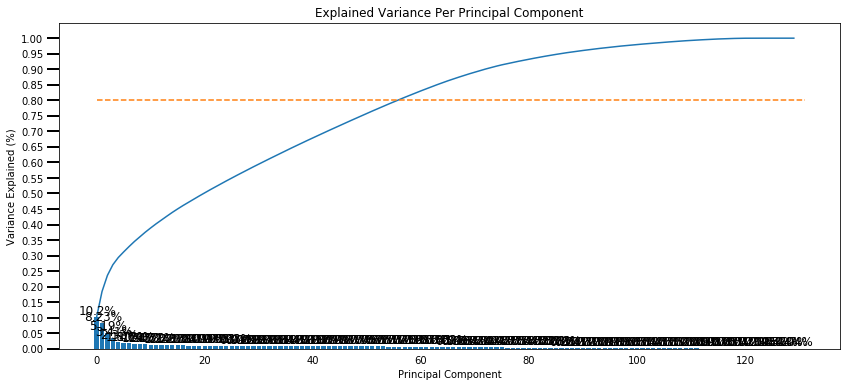

In [37]:
plot(pca)

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_2 = PCA(56,whiten=True,random_state=42)
df = pca_2.fit_transform(df)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Each component is made up of a combination of 130 features which we got after cleaning. The higher the weight of the feature, more is it's impact on the principal component. We're retaining 56 transformed features since it represents 80% of the variance in the data as it's visible from the plot.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def show_pca_weights(principal_component,no_of_weights):
    
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca_2.components_)+1)]
    
    ratio = pd.DataFrame(pca_2.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(4)
    ratio.index = dimensions
    
    weights = pd.DataFrame(pca_2.components_, columns=headers)
    weights = weights.round(4)
    weights.index = dimensions
    
    result = pd.concat([ratio, weights], axis = 1, join_axes=[ratio.index])
    result[:5]
    print("Principal Component", (principal_component))
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values(ascending=False)[:no_of_weights])
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values()[:no_of_weights])


In [40]:
show_pca_weights(1,10)

Principal Component 1
------------------------------
HH_EINKOMMEN_SCORE    0.1861
PLZ8_ANTG3            0.1847
CAMEO_TENS            0.1819
PLZ8_ANTG4            0.1776
FINANZ_SPARER         0.1620
ORTSGR_KLS9           0.1570
EWDICHTE              0.1552
FINANZTYP_1           0.1431
FINANZ_HAUSBAUER      0.1398
LP_STATUS_FEIN_2.0    0.1378
Name: PC 1, dtype: float64
------------------------------
FINANZ_MINIMALIST      -0.2159
MOBI_REGIO             -0.1955
KBA05_ANTG1            -0.1864
PLZ8_ANTG1             -0.1853
KBA05_GBZ              -0.1820
KONSUMNAEHE            -0.1364
PLZ8_GBZ               -0.1350
ALTERSKATEGORIE_GROB   -0.1315
INNENSTADT             -0.1301
FINANZ_VORSORGER       -0.1285
Name: PC 1, dtype: float64


In [41]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_pca_weights(2,10)

Principal Component 2
------------------------------
ALTERSKATEGORIE_GROB    0.2139
FINANZ_VORSORGER        0.1990
ZABEOTYP_3              0.1973
SEMIO_ERL               0.1745
RETOURTYP_BK_S          0.1537
SEMIO_LUST              0.1495
LP_STATUS_FEIN_1.0      0.1262
W_KEIT_KIND_HH          0.1223
FINANZ_HAUSBAUER        0.1193
PLZ8_ANTG3              0.1122
Name: PC 2, dtype: float64
------------------------------
DECADE                  -0.2112
FINANZ_UNAUFFAELLIGER   -0.2024
SEMIO_REL               -0.2007
FINANZ_SPARER           -0.1996
SEMIO_TRADV             -0.1945
FINANZ_ANLEGER          -0.1894
SEMIO_PFLICHT           -0.1880
ONLINE_AFFINITAET       -0.1694
SEMIO_KULT              -0.1610
SEMIO_RAT               -0.1497
Name: PC 2, dtype: float64


In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_pca_weights(3,10)

Principal Component 3
------------------------------
SEMIO_VERT           0.3245
SEMIO_FAM            0.2616
SEMIO_SOZ            0.2593
SEMIO_KULT           0.2506
FINANZTYP_5          0.1374
FINANZ_MINIMALIST    0.1285
SHOPPER_TYP_0.0      0.1249
SEMIO_REL            0.1096
ZABEOTYP_1           0.1094
SEMIO_MAT            0.0863
Name: PC 3, dtype: float64
------------------------------
ANREDE_KZ            -0.3503
SEMIO_KAEM           -0.3206
SEMIO_DOM            -0.2905
SEMIO_KRIT           -0.2677
SEMIO_ERL            -0.2044
SEMIO_RAT            -0.1627
FINANZ_ANLEGER       -0.1566
FINANZTYP_1          -0.1040
SHOPPER_TYP_2.0      -0.0949
LP_STATUS_FEIN_2.0   -0.0837
Name: PC 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The first component makes up 10.2% of the total variance and 56 components make up 80% of the total variance. Each component is a combination of 130 features. The higher the magnitude of the features the more is their impact on the principal component regardless of their sign (+ve or -ve). 

For the first the principal component top positive features are HH_EINKOMMEN_SCORE, PLZ8_ANTG3, CAMEO_TENS, PLZ8_ANTG4 and the top negative features are FINANZ_MINIMALIST, MOBI_REGIO, KBA05_ANTG1. Positive features relate to household income, 6-10 and 10+ houses in PLZ8 region and wealth. Negative features relate to financial topology, movement patterns and no. of 1-2 houses in the family cell.

For the second principal component top positive features are  ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3, SEMIO_ERL and the top negative features are DECADE, FINANZ_UNAUFFAELLIGER, SEMIO_REL, FINANZ_SPARER. Positive features relate to estimated age, people who're financially prepared, fair supplied energy consumption and people with event oriented personality. Negative features relate to generation by decade, inconspicuous spenders, religious and money saver people.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
from sklearn.cluster import KMeans
def kmeans_score(data, center):
    
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score    

In [50]:
# Over a number of different cluster counts...
score = []
#centroids = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]
centroids = [2, 5, 10, 15, 20, 25]
    # run k-means clustering on the data and...
for x in centroids:
    score.append(kmeans_score(df,x))

In [51]:
    # compute the average within-cluster distances.
    
score_series = pd.Series(score)
centroids_series = pd.Series(centroids)
score_df = pd.concat([centroids_series,score_series],axis=1)
score_df.columns = ['clusters','average_distance']
score_df.set_index('clusters',inplace=True)
score_df['average_distance'] = score_df['average_distance'].round(0)
#score_df[:]
print(score_df)

          average_distance
clusters                  
2               42691253.0
5               40520560.0
10              37564918.0
15              35321531.0
20              33144841.0
25              31232054.0


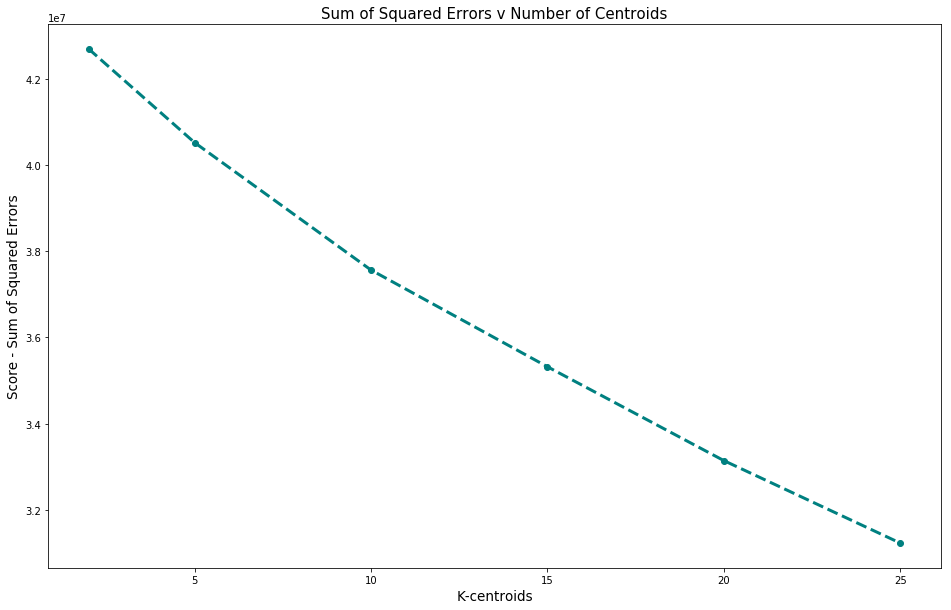

In [52]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig = plt.subplots(figsize=(16,10))
ax = plt.subplot(111)
plt.plot(centroids,score,linestyle='--',linewidth=3,marker='o',color='teal')

ax.set_xlabel('K-centroids', fontsize=13.5)
ax.set_ylabel('Score - Sum of Squared Errors', fontsize=13.5)
plt.title('Sum of Squared Errors v Number of Centroids',fontsize=15);

In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_1 = KMeans(n_clusters=10, n_init=10, max_iter=300, random_state=42)
population_clusters = kmeans_1.fit_predict(df)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

With 56 principal components, we see 10 porints resembling an elbow. The lower number of clusters give uniform distribution but higher number of clusters give more difference in the counts allocated to clusters in general.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [55]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_2 = clean_data(customers)
df_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSRTEAM,DECADE,CAMEO_TENS,CAMEO_ONES
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,0.0,2.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,1,0,0,0,0,0.0,2.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,1,0,0,0,0,0,1.0,1.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,1,0,0,1.0,4.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,1,0,0,0,0,0.0,2.0,3.0,4.0


In [57]:
headers_2 = list(df_2.columns.values)

In [58]:
df_2 = imputer.transform(df_2)
df_2 = pd.DataFrame(df_2)
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,4.0,1.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0


In [59]:
df_2.isnull().any().sum()

0

In [60]:
df_2 = stdscaler.fit_transform(df_2)
df_2 = pd.DataFrame(df_2)
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,0.700339,-0.701245,0.718516,-0.511661,0.510944,-0.597636,0.161437,-0.563877,0.997381,-1.263018,...,-0.430980,-0.297850,-0.39114,-0.283813,-0.318679,-0.216903,-0.997381,-0.657787,-1.135764,-0.274577
1,0.700339,1.426035,0.718516,-0.511661,0.510944,-0.597636,2.236891,0.958010,0.997381,0.024269,...,-0.430980,3.357396,-0.39114,-0.283813,-0.318679,-0.216903,-0.997381,-0.657787,0.285118,0.471222
2,0.700339,-0.701245,0.718516,-0.511661,0.510944,0.404982,-0.876290,-0.563877,-1.002625,0.024269,...,2.320291,-0.297850,-0.39114,-0.283813,-0.318679,-0.216903,1.002625,-1.391591,-0.425323,0.471222
3,-0.682034,-0.701245,-1.251211,-0.511661,-0.683548,2.410218,3.274618,-0.563877,-1.002625,1.311557,...,-0.430980,-0.297850,-0.39114,3.523447,-0.318679,-0.216903,1.002625,0.809820,0.995559,-1.766175
4,-0.682034,-0.701245,0.718516,-0.511661,0.510944,-0.597636,0.161437,0.197067,0.997381,1.311557,...,-0.430980,3.357396,-0.39114,-0.283813,-0.318679,-0.216903,-0.997381,-0.657787,0.285118,0.471222


In [61]:
df_2 = pca_2.transform(df_2)
df_2 = pd.DataFrame(df_2)
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-1.074565,0.058278,0.999917,0.322380,-1.605383,1.577523,0.828493,0.334054,0.301959,-0.568872,...,-0.809787,0.033725,0.423603,0.544152,0.461259,0.518818,1.075329,-0.820505,0.143638,-1.204085
1,0.018225,1.247048,-1.034515,0.737072,-0.991310,-1.229137,0.253041,-0.357533,-1.328130,-0.149925,...,-1.639307,-0.389292,1.152541,0.178146,-0.439088,-0.479059,0.083058,0.563720,0.147505,0.152395
2,-0.693662,-0.390603,0.544515,-1.959631,-0.166429,-0.005276,-0.077876,0.776316,-0.189944,0.811822,...,0.103418,0.384041,-0.723162,0.254921,0.340241,-0.103207,0.100875,0.204563,-0.439409,0.723751
3,1.254900,-0.681126,0.046523,-0.283929,1.237663,0.827772,-1.513591,-0.789286,0.234182,-0.323103,...,1.512632,-0.097247,0.468256,-0.579898,-0.937307,1.434163,1.615310,1.210853,1.287581,0.759885
4,0.047268,-0.077270,0.704685,0.991682,-0.836960,0.464264,-1.228757,-0.217791,1.097508,-0.895543,...,-0.596247,-1.415540,1.412078,-0.129188,-0.835860,-0.593784,-0.260257,-0.671505,-0.511526,0.189174


In [62]:
customer_clusters = kmeans_1.predict(df_2)

In [63]:
row_missing_2 = customers.isnull().sum(axis=1)
customer_deleted = customers[customers.index.isin(row_missing_2[row_missing_2 > 9].index)]

In [64]:
customer_deleted.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
10,NaN,3.0,2,5.0,4,2,4,4,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,4.0,1,6.0,5,3,4,2,3,1,...,4.0,1.0,0.0,0.0,1.0,3.0,4.0,4.0,6.0,5.0
36,NaN,1.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [65]:
customer_clusters = pd.Series(customer_clusters)
c_clusters = customer_clusters.value_counts().sort_index()
c_clusters = pd.Series(c_clusters)
print(c_clusters)

0    13265
1     2638
2    15579
3    14937
4    20559
5     7908
6    15566
7    24032
8    19437
9     2238
dtype: int64


In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_clusters = pd.Series(population_clusters)
p_clusters = population_clusters.value_counts().sort_index()
p_clusters = pd.Series(p_clusters)
print(p_clusters)

0     50629
1     53424
2     66046
3     57700
4    214510
5     49121
6     73911
7     92147
8    106977
9     10278
dtype: int64


In [78]:
final = pd.concat([p_clusters, c_clusters], axis=1).reset_index()
final.columns = ['cluster','population','customer']
final

,cluster,population,customer
0,0,50629,13265
1,1,53424,2638
2,2,66046,15579
3,3,57700,14937
4,4,214510,20559
5,5,49121,7908
6,6,73911,15566
7,7,92147,24032
8,8,106977,19437
9,9,10278,2238


Text(0.5,1,'Distribution of Customers into Population Clusters')

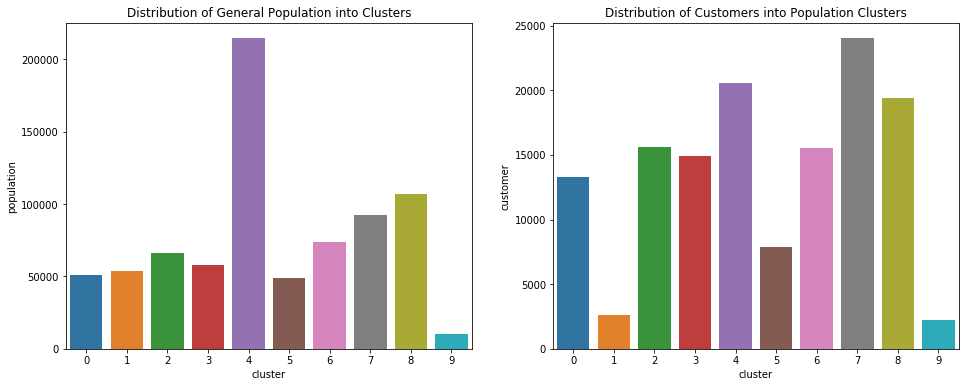

In [79]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='cluster',y='population',data=final)
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='cluster',y='customer',data=final)
plt.title("Distribution of Customers into Population Clusters")

In [80]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
final['population%'] = (final['population']/final['population'].sum()*100).round(2)
final['customer%'] = (final['customer']/final['customer'].sum()*100).round(2)
final['difference'] = final['customer%'] - final['population%']
final


,cluster,population,customer,population%,customer%,difference
0,0,50629,13265,6.53,9.74,3.21
1,1,53424,2638,6.90,1.94,-4.96
2,2,66046,15579,8.52,11.44,2.92
3,3,57700,14937,7.45,10.97,3.52
4,4,214510,20559,27.69,15.10,-12.59
5,5,49121,7908,6.34,5.81,-0.53
6,6,73911,15566,9.54,11.43,1.89
7,7,92147,24032,11.89,17.65,5.76
8,8,106977,19437,13.81,14.28,0.47
9,9,10278,2238,1.33,1.64,0.31


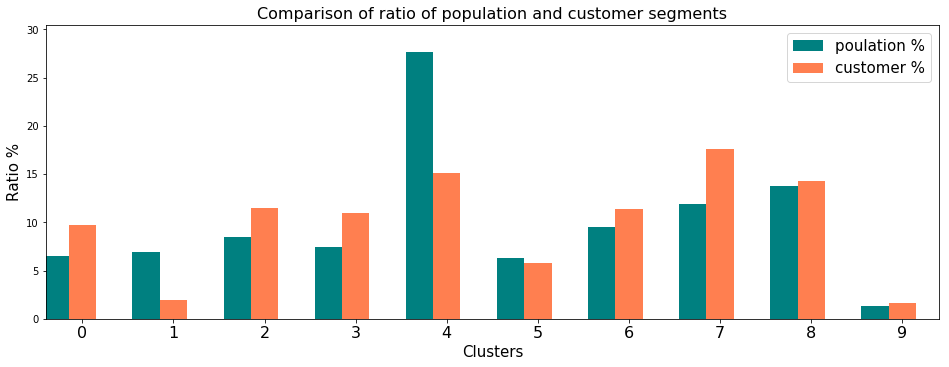

In [81]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = final['population%'].plot(x=final['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = final['customer%'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
#ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of population and customer segments')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.show()

In [82]:
azdias_2.shape

(116478, 78)

In [83]:
customer_deleted.shape

(61179, 85)

In [84]:
final.loc[10] = ['10', azdias_2.shape[0], customer_deleted.shape[0],0,0,0]  # adding a row
final.sort_index(inplace=True)

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
final['population%'] = (final['population']/final['population'].sum()*100).round(2)
final['customer%'] = (final['customer']/final['customer'].sum()*100).round(2)
final['difference'] = final['customer%'] - final['population%']
final

,cluster,population,customer,population%,customer%,difference
0,0,50629,13265,5.68,6.72,1.04
1,1,53424,2638,5.99,1.34,-4.65
2,2,66046,15579,7.41,7.89,0.48
3,3,57700,14937,6.47,7.57,1.10
4,4,214510,20559,24.07,10.42,-13.65
5,5,49121,7908,5.51,4.01,-1.50
6,6,73911,15566,8.29,7.89,-0.40
7,7,92147,24032,10.34,12.18,1.84
8,8,106977,19437,12.00,9.85,-2.15
9,9,10278,2238,1.15,1.13,-0.02


Text(0.5,1,'Distribution of Customers into Population Clusters')

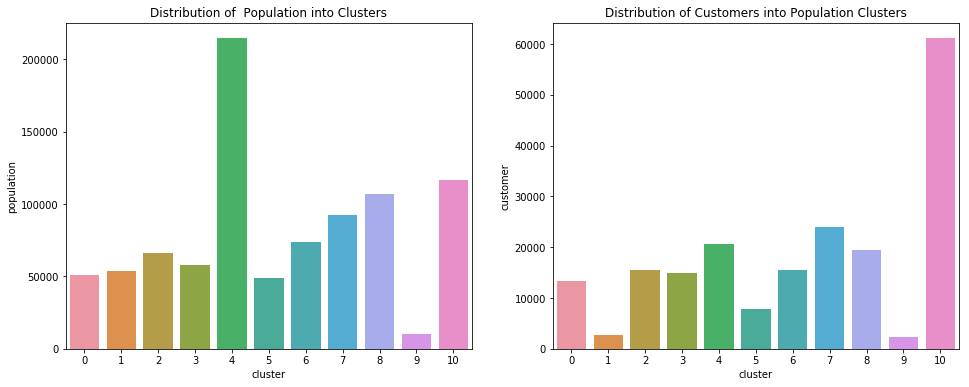

In [87]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x=final['cluster'],y=final['population'],data=final)
plt.title("Distribution of  Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x=final['cluster'],y=final['customer'],data=final)
plt.title("Distribution of Customers into Population Clusters")

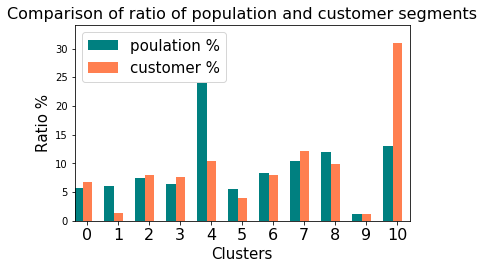

In [88]:
ax = fig.add_subplot(111)

ax = final['population%'].plot(x=final['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = final['customer%'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
#ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of population and customer segments')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.show()

In [104]:
cluster_center = kmeans_1.cluster_centers_[7]
cluster_center = pd.Series(cluster_center)
cluster_center.sort_values(ascending=False)

36    1.103640
32    0.934948
34    0.807469
33    0.559392
39    0.473249
22    0.426474
41    0.407465
26    0.373210
50    0.341211
12    0.321952
25    0.318346
5     0.277842
24    0.227635
7     0.224166
3     0.217754
55    0.208406
46    0.177041
27    0.137813
40    0.115632
9     0.087819
1     0.085796
52    0.071477
16    0.055439
20    0.054478
42    0.045688
19    0.042192
18    0.031361
11    0.027858
13    0.009723
38    0.008433
49    0.006732
51   -0.001719
2    -0.002132
21   -0.004587
6    -0.009517
28   -0.019986
15   -0.028201
37   -0.045119
4    -0.057963
48   -0.092004
30   -0.099087
0    -0.105607
47   -0.113957
8    -0.116492
45   -0.119435
54   -0.150173
10   -0.165926
17   -0.174466
44   -0.200419
29   -0.232037
53   -0.352490
35   -0.357356
43   -0.421405
31   -0.433601
14   -0.617923
23   -0.690310
dtype: float64

In [105]:
cluster_center_2 = stdscaler.inverse_transform(pca_2.inverse_transform(cluster_center))
cluster_center_2 = pd.Series(cluster_center_2)
cluster_center_2.index = headers
cluster_center_2

ALTERSKATEGORIE_GROB     3.563799
ANREDE_KZ                1.348185
FINANZ_MINIMALIST        4.309526
FINANZ_SPARER            1.356663
FINANZ_VORSORGER         4.724991
FINANZ_ANLEGER           1.469979
FINANZ_UNAUFFAELLIGER    1.826117
FINANZ_HAUSBAUER         2.590187
GREEN_AVANTGARDE         0.538461
HEALTH_TYP               1.978998
RETOURTYP_BK_S           3.899847
SEMIO_SOZ                4.280234
SEMIO_FAM                3.736052
SEMIO_REL                2.990052
SEMIO_MAT                3.213074
SEMIO_VERT               5.179411
SEMIO_LUST               5.576900
SEMIO_ERL                5.043273
SEMIO_KULT               3.745264
SEMIO_RAT                2.780568
SEMIO_KRIT               3.895669
SEMIO_DOM                4.071424
SEMIO_KAEM               3.704535
SEMIO_PFLICHT            2.875192
SEMIO_TRADV              2.835773
SOHO_KZ                  0.003279
VERS_TYP                 1.487307
ANZ_PERSONEN             2.444462
ANZ_TITEL                0.020419
HH_EINKOMMEN_S

In [106]:
show_pca_weights(36,2)

Principal Component 36
------------------------------
GFK_URLAUBERTYP_11.0    0.4529
CJT_GESAMTTYP_1.0       0.2860
Name: PC 36, dtype: float64
------------------------------
GFK_URLAUBERTYP_8.0   -0.322
CAMEO_DEUG_2015_2     -0.249
Name: PC 36, dtype: float64


In [107]:
show_pca_weights(32,2)

Principal Component 32
------------------------------
CAMEO_DEUG_2015_4     0.3235
LP_STATUS_FEIN_6.0    0.2453
Name: PC 32, dtype: float64
------------------------------
CAMEO_DEUG_2015_6   -0.2725
CAMEO_DEUG_2015_2   -0.2652
Name: PC 32, dtype: float64


In [109]:
cluster_center2 = kmeans_1.cluster_centers_[9]
cluster_center2 = pd.Series(cluster_center2)
cluster_center2.sort_values(ascending=False)

47    5.970177
45    3.085986
48    1.418144
40    0.946720
35    0.719626
29    0.695692
23    0.671852
27    0.671439
4     0.364741
5     0.348720
34    0.340023
19    0.307507
36    0.293317
20    0.238242
3     0.232522
6     0.206721
12    0.199598
37    0.183292
9     0.140253
52    0.131625
8     0.093386
25    0.085427
26    0.015542
10    0.005120
55   -0.022879
31   -0.023556
2    -0.026342
0    -0.042333
16   -0.057164
7    -0.060956
21   -0.091202
39   -0.096073
24   -0.129804
53   -0.158386
22   -0.220465
11   -0.230034
14   -0.275712
1    -0.280288
50   -0.316775
15   -0.332312
33   -0.342695
54   -0.343512
17   -0.343786
32   -0.345958
13   -0.346630
41   -0.433150
28   -0.470187
18   -0.490320
30   -0.505087
43   -0.542345
49   -0.958682
38   -1.053926
42   -1.188489
44   -1.469371
46   -2.343401
51   -2.684898
dtype: float64

In [110]:
cluster_center2_2 = stdscaler.inverse_transform(pca_2.inverse_transform(cluster_center2))
cluster_center2_2 = pd.Series(cluster_center2_2)
cluster_center2_2.index = headers
cluster_center2_2

ALTERSKATEGORIE_GROB     3.404429
ANREDE_KZ                1.327820
FINANZ_MINIMALIST        4.222933
FINANZ_SPARER            1.586619
FINANZ_VORSORGER         4.483994
FINANZ_ANLEGER           1.759026
FINANZ_UNAUFFAELLIGER    1.999002
FINANZ_HAUSBAUER         2.524506
GREEN_AVANTGARDE         0.565544
HEALTH_TYP               1.729024
RETOURTYP_BK_S           3.689366
SEMIO_SOZ                4.265297
SEMIO_FAM                3.881322
SEMIO_REL                3.234169
SEMIO_MAT                3.351142
SEMIO_VERT               5.268916
SEMIO_LUST               5.523504
SEMIO_ERL                4.720413
SEMIO_KULT               4.007757
SEMIO_RAT                2.933967
SEMIO_KRIT               3.629440
SEMIO_DOM                3.895087
SEMIO_KAEM               3.576699
SEMIO_PFLICHT            3.053584
SEMIO_TRADV              3.129603
SOHO_KZ                  0.000417
VERS_TYP                 1.564172
ANZ_PERSONEN             3.313080
ANZ_TITEL                0.025665
HH_EINKOMMEN_S

In [111]:
show_pca_weights(47,2)

Principal Component 47
------------------------------
LP_FAMILIE_FEIN_7.0     0.3288
NATIONALITAET_KZ_3.0    0.2848
Name: PC 47, dtype: float64
------------------------------
CAMEO_DEUG_2015_5     -0.3393
LP_FAMILIE_FEIN_6.0   -0.3197
Name: PC 47, dtype: float64


In [112]:
show_pca_weights(45,2)

Principal Component 45
------------------------------
GFK_URLAUBERTYP_6.0    0.4528
GFK_URLAUBERTYP_4.0    0.2950
Name: PC 45, dtype: float64
------------------------------
GFK_URLAUBERTYP_1.0   -0.2729
LP_FAMILIE_FEIN_7.0   -0.2681
Name: PC 45, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

For population dataset, cluster 4 has highest count of 214510 and cluster 9 has lowest count of 10278. For customer dataset, cluster 7 has highest count of 24032 and cluster 9 has lowest count of 2238. It is clear that clusters 1, 4 and 5 are under-represented for customer dataset. 

It is clear that cluster 7 has the highest importance for customer dataset. Also, looks like missing row data is having very high impact since 31% of data from customer dataset is missing. On further analysis of the principal component 36, we find that active families and advertising and consumption minimalist have the most positive weights. Homeland-connected vacationists and upper middle class families have most negative weights. From principal component 32, we understand that the consumption-oriented middleclass and independent workers have most positive weightage whereas low-consumption middleclass and upper middle class have most negative weightage.

Also, 9th cluster is of least relevance. On further analysis of the principal component 47, we find the most positive weightage is for families with the teenagers and people with assimilated names whereas the most negative weight is for active middle class and young family. For the principal component 45, highest weightage is for hikers and culture lovers whereas the event travellers and family with a teenager have most negative weight.




> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.